## Implementación de Redes Generativas Antagónicas (GAN)

### Aplicación sobre el dataset MNIST

**Autor:** Danny Javier Mota


Este notebook implementa el paper de Goodfellow et al.(https://arxiv.org/pdf/1406.2661.pdf) que propone "...un nuevo esquema para la estimacion de modelos generativos mediante un proceso advesarial, en el que simultaneamente entrenamos dos modelos: un modelo G generativo que captura la distribucion de los datos y un modelo D discriminativo que estima la probabilidad de que una muestra provenga de los datos de entrenamientos o del modelo G..."

**Arquitectura basica de las GANs**:

## Arquitectura de una Red Generativa Adversaria (GAN)

La arquitectura de una **Red Generativa Adversaria (GAN)** se basa en la interacción competitiva entre dos redes neuronales distintas: el **Generador** y el **Discriminador**.

---

### 1. El Generador ($G$)

El objetivo del generador es aprender a producir datos sintéticos que sean indistinguibles de los datos reales.

- **Entrada:**  
  Recibe un vector de ruido aleatorio $z$, proveniente de un espacio latente, usualmente con una distribución normal o uniforme.

- **Proceso:**  
  Transforma el vector de ruido mediante capas neuronales (frecuentemente densas o convolucionales) hasta generar una muestra con las mismas dimensiones que los datos reales.

- **Objetivo:**  
  Maximizar el error del discriminador, logrando que este clasifique las muestras generadas como si fueran reales.

---

### 2. El Discriminador ($D$)

El discriminador actúa como un clasificador binario que intenta distinguir la autenticidad de los datos.

- **Entrada:**  
  Recibe alternadamente muestras del conjunto de datos real y muestras producidas por el generador.

- **Proceso:**  
  Analiza las características de la entrada y asigna una probabilidad (normalmente entre 0 y 1) que indica la probabilidad de que la muestra sea real.

- **Objetivo:**  
  Minimizar el error de clasificación, identificando correctamente cuándo una muestra es real y cuándo ha sido creada por el modelo $G$.

---

### 3. Proceso Adversarial (Juego de Minimax)

El entrenamiento de una GAN se define matemáticamente como un **juego de suma cero**, donde el valor de la función de pérdida se rige por la siguiente dinámica:

- El **Discriminador ($D$)** intenta maximizar la probabilidad de asignar la etiqueta correcta tanto a los ejemplos reales como a las muestras generadas por $G$.
- El **Generador ($G$)** intenta minimizar la probabilidad de que $D$ detecte que sus muestras son falsas.

Este proceso continúa hasta alcanzar un equilibrio en el cual el generador es capaz de producir datos tan realistas que el discriminador no puede diferenciarlos de los datos reales, obteniendo una probabilidad de acierto cercana al **50%**, equivalente a una decisión aleatoria.


## Imports


In [1]:
#Realizamos los imports necesarios
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

## Setup


In [2]:
#Definimos el device a utilizar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
folder_datos = './MNIST_data/'
if not os.path.exists(folder_datos):
  os.mkdir(folder_datos)

In [5]:
#Hyperparametros
BATCH_SIZE = 64
LR = 0.0002
EPOCHS  = 30
IMAGE_SIZE = 28
LATENT_DIM = 100

### Carga de Datos

*   Defininimos las transforms para convertir los datos de entramiento a tensores y para normalizar los mismos.
*   Descargamos el dataset MNIST y aplicamos las transformaciones
*   Definimos el dataloader utilizando el batch_size establecido anteriormente.


In [6]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = datasets.MNIST(root=folder_datos, train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.34MB/s]


## Generator


Tanto el Generador como el Discriminador tienen una architectura compuesta de capas fully connected. El generador utiliza RELU
como funcion de activacion y el Discriminador utiliza LeakyReLu para prevenir que pase de zero su salida.

El generador cuenta con 4 capas fully connected, donde la entrada es el latent vector (Z = 100 segun el paper) y en las
siguientes capas establecemos los feautures en 256 -> 512 -> 1024.


In [7]:
class Generator_Network(nn.Module):
    def __init__(self, ginput, goutput):
        super(Generator_Network, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, goutput),
            nn.Tanh())
    def forward(self, input):
        return self.main(input)

### Discriminator

Ahora construimos el discriminador. Con la cantidad de features por capas puestos a la inversa del generador. Adicionalmente incorpora capas de dropout entre los fully connected layers.

Este modelo es un clasificador que evalua la salida del generador mediante probabilidad condicional P(Y|X). Determinara si las imagenes generadas por el Generator dejan de "aparentar" ser falsas.


In [8]:
class Discriminator_Network(nn.Module):
    def __init__(self, dinput, output = 1):
        super(Discriminator_Network, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() )
    def forward(self, input):
        return self.main(input)

## Utils


In [9]:
#funcion para generar las imagenes a mostrar
def genimagenes(fake, epoch = 0, batch = 0, device = None):
  images = []
  num_imagenes = 16
  images = fake
  plt.figure(figsize=(8, 8))
  for i in range(num_imagenes):
    image = images[i]
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [10]:
#creamos ruido random
def create_noise(num, latentdim):
    return torch.randn(num, latentdim)

### Entrenamiento


El proceso de entrenamiento de las GANs consiste un juego de minimax, donde el Discriminador debe aprender a minimizar el error en la distincion de imagenes generadas vs reales (provenientes del dataset). El Generador debe aprender a maximizar la probabilidad de que el Discriminador cometa un error.
  
 Dentro de el training loop en el discriminador entrena primero por un (o varios) epochs, luego entrenamos el generador por uno (o varios) epochs. Continuamos dicho proceso, manteniendo el generador sin entrear durante el entrenamiento del discriminador de tal forma que este ultimo pueda llevar a cabo el proceso de aprendizaje sobre un objetivo firme.

 En teoria, el punto de equilibrio se alcanzaria al momento que la informacion producida por el generador sea clasificada por
 el discriminador, de la misma manera que este clasificaria las infomacion original. Evidentemene, en la practica esto es dificil de alcanzar, por lo que buscamos optimizar los modelos mediante experimentacion y emplear tecnicas mas avanzadas (DCGAN, Vanilla GAN, etc) para mejorar los resultados.

 Para computar la loss utilizamos Binary Cross Entropy ya que buscamos clasificar entre dos clases.

 En alto nivel, podemos establecer el proceso de entramiento del algoritmo de la siguiente forma:

 Entrenar D:
 * Computar la loss sobre imagenes del training dataset
 * Generar imagenes
 * Computar la loss sobre imagenes generadas
 * Sumar ambas loss
 * Backpropagation
 * Actualizar pesos del modelo

 Entrenar G:
 * Generar imagenes
 * Computar la loss sobre las imagenes generadas (utilizando los labels verdaderos)
 * Backpropagation
 * Actualizar pesos

 El pseudo-codigo del entrenamiento de las GANs se presenta a continuacion:


In [11]:
#tracking variables
loss_generator = []
loss_discriminator = []

In [ ]:
def train(dataloader):

    #Inicializamos Generator y Discriminator
    Generator = Generator_Network(LATENT_DIM, IMAGE_SIZE * IMAGE_SIZE).to(device)
    Discriminator = Discriminator_Network(IMAGE_SIZE * IMAGE_SIZE, 1).to(device)

    #Loss
    criterion = nn.BCELoss().to(device)

    #Optimizer
    G_optimizer = torch.optim.Adam(Generator.parameters(), lr=LR)
    D_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        Generator.train()
        Discriminator.train()
        Loss_G = []
        Loss_D = []
        for i, data in enumerate(dataloader, 0):

            image = data[0].to(device)
            b_size = len(image)

            # labels
            real_label = torch.ones(b_size, 1).to(device)
            fake_label = torch.zeros(b_size, 1).to(device)

            # imagenes generadas
            data_fake = Generator(create_noise(b_size, LATENT_DIM).to(device))
            data_real = image.view(b_size, IMAGE_SIZE * IMAGE_SIZE)

            #train  discriminator
            output_real = Discriminator(data_real)
            output_fake = Discriminator(data_fake)
            loss_real = criterion(output_real, real_label)
            loss_fake = criterion(output_fake, fake_label)
            loss_d = loss_real + loss_fake

            # back propagation
            D_optimizer.zero_grad()
            loss_d.backward()
            D_optimizer.step()

            #train generator network
            data_fake = Generator(create_noise(b_size, LATENT_DIM).to(device))

            #computamos la loss para generator
            output_fake = Discriminator(data_fake)
            loss_g = criterion(output_fake, real_label)

            ## back propapagation
            G_optimizer.zero_grad()
            loss_g.backward()
            G_optimizer.step()

            ## guardamos la loss
            Loss_D.append(loss_d.item())
            Loss_G.append(loss_g.item())

            epoch_loss_g = np.mean(Loss_G)
            epoch_loss_d = np.mean(Loss_D)

        print("Epoch: %d" % (epoch + 1))
        print("Generator loss: %.8f, Discriminator loss: %.8f" % (epoch_loss_g, epoch_loss_d))

        if (epoch % 5 == 0) and (i == len(dataloader)-1):
            with torch.no_grad():
                noise = Generator(create_noise(25, 100).to(device))
                genimagenes(noise, epoch = epoch, batch = 0, device = device )

        loss_generator.append(epoch_loss_g)
        loss_discriminator.append(epoch_loss_d)

Epoch: 1
Generator loss: 1.71716617, Discriminator loss: 1.17128762
Epoch: 2
Generator loss: 1.51974696, Discriminator loss: 1.08481368
Epoch: 3
Generator loss: 2.14400497, Discriminator loss: 0.82756286
Epoch: 4
Generator loss: 2.47725936, Discriminator loss: 0.62228334
Epoch: 5
Generator loss: 2.26800833, Discriminator loss: 0.66145836
Epoch: 6
Generator loss: 2.39523569, Discriminator loss: 0.61775159
Epoch: 7
Generator loss: 2.19053899, Discriminator loss: 0.68016245
Epoch: 8
Generator loss: 2.09005153, Discriminator loss: 0.71614687
Epoch: 9
Generator loss: 1.90286258, Discriminator loss: 0.78220358
Epoch: 10
Generator loss: 1.64027762, Discriminator loss: 0.89634455
Epoch: 11
Generator loss: 1.70753148, Discriminator loss: 0.85905301
Epoch: 12
Generator loss: 1.60668082, Discriminator loss: 0.90822607
Epoch: 13
Generator loss: 1.59536059, Discriminator loss: 0.91627466
Epoch: 14
Generator loss: 1.56272291, Discriminator loss: 0.92450101
Epoch: 15
Generator loss: 1.44498385, Discr

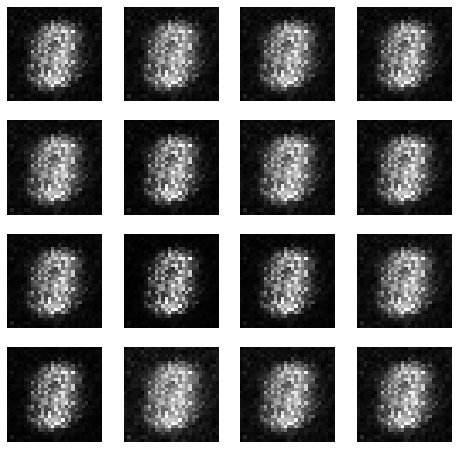

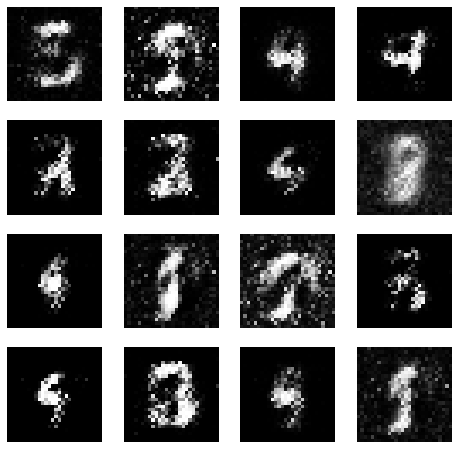

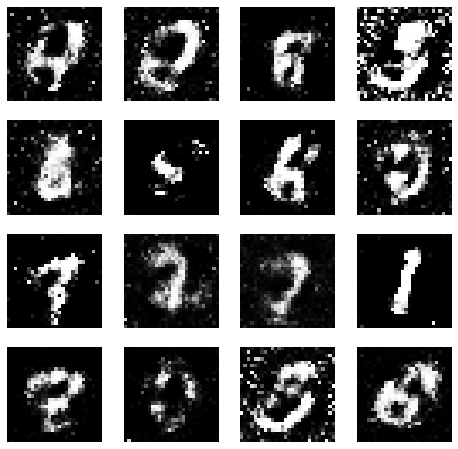

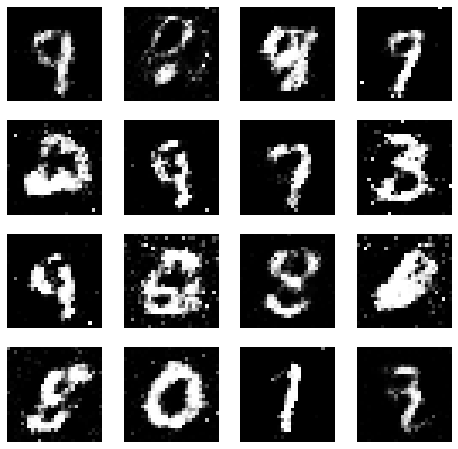

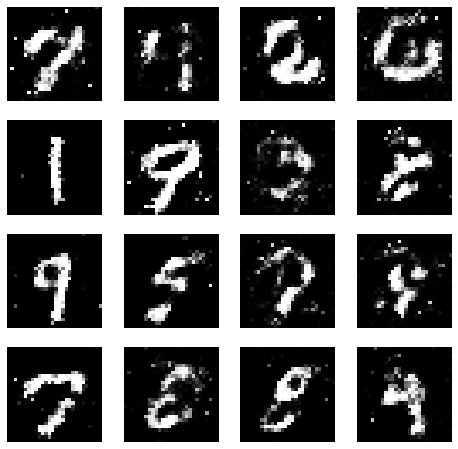

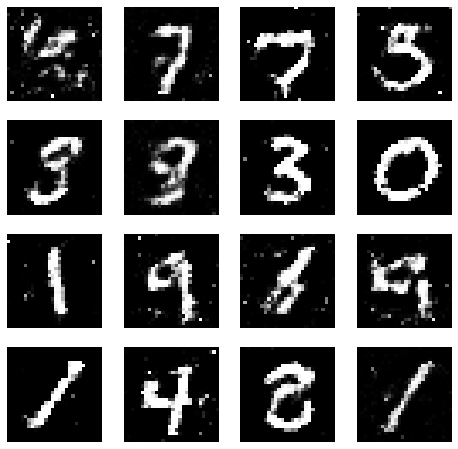

In [ ]:
train(train_loader)

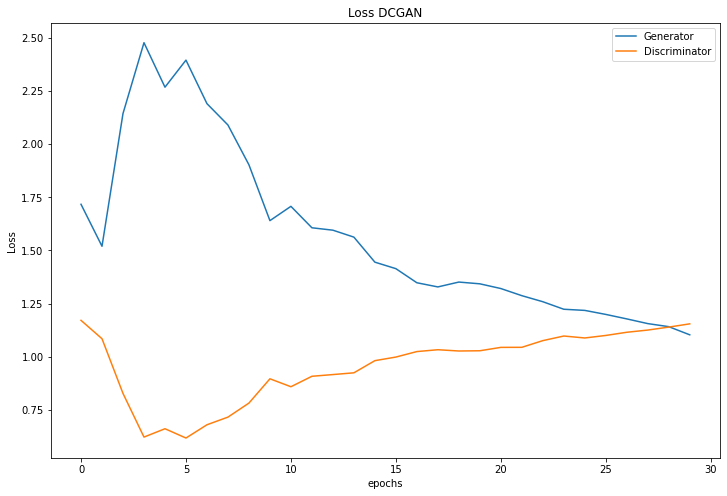

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Loss DCGAN")
plt.plot(loss_generator,label="Generator")
plt.plot(loss_discriminator,label="Discriminator")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Conclusion


Tras 30 epochs podemos observar que las GANs lograron generar imagenes en concordancia con el dataset original. Viendo el curso de los resultados puedo inferir que de entrenar por una mayor cantidad de epochs este mejoraria aun mas. De hecho, esto lo pude notar en corridas anteriores de hasta 100 epochs. Por limitaciones de GPU las ultimas corridas, despues de corregir fallos en el training loop, fueron de 30.

Al comparar la grafica de la loss con la curva ideal de un minimax game, es evidente que hay fluctuaciones considerables en el aprendizaje de los modelos. Aproximadamente, entre el epoch 1 y el epoch 6 observamos un pico en la loss del Generador, y un valle considerable en el Discriminador. Lo que me da notar que este ultimo se fue "vencido" muy rapidamente, asumiendo como validas imagenes generadas que mayormente contenian ruido. A partir del epoch 10 podemos ver una progresion mas adecuada del entrenamiento adversarial, lo que se evidencia en las imagenes resultantes. En el caso ideal esperariamos que la loss del discriminador tienda a cero y la que del Generador se estabilize. En este caso estariamos llegando al punto de equilibro mencionado anteriormente.

Para mejorar, seria necesario evaluar los resultados de manera comparativa tras una mayor cantidad de epochs. Experimentando con diferentes metodos de data augmentation, y optimizacion de hiperparametros.
